<a href="https://colab.research.google.com/github/msasen/pytorch/blob/main/1-transform-islemleri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1-transform-islemleri.ipynb
from google.colab import files
uploaded = files.upload()

Saving Ekran Resmi 2023-02-10 14.29.05.png to Ekran Resmi 2023-02-10 14.29.05.png


In [ ]:
!pip install torch torchvision


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import torchvision.transforms as T
from torch.nn.functional import normalize
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


# Transforms'ları anlamak 
## 1) Resize
  Resize() dönüşümü girdi görüntüsünü belirli bir boyuta yeniden boyutlandırır. Torchvision.transforms modülü tarafından sağlanan dönüşümlerden biridir. Resize() hem PIL hem de tensör görüntülerini kabul eder. Bir tensör görüntüsü [C, H, W] şeklinde bir torch tensörüdür; burada C kanal sayısı, H görüntü yüksekliği ve W görüntü genişliğidir.

Bu dönüşüm aynı zamanda [B, C, H, W] şeklinde bir tensör olan bir tensör görüntü grubunu da kabul eder; burada B, gruptaki görüntü sayısıdır. Bir görüntü PIL yada tensör görüntüsü değilse, önce onu tensör görüntüsüne dönüştürürüz ve ardından Resize()dönüşümünü uygularız.

In [ ]:
img = Image.open('/content/resim.png')
print(type(img))
# Açıklama aşağıda
print(img.mode) 
print(img)
if img.mode == 'CMYK' or img.mode == 'RGBA':
    img = img.convert('RGB')
print(img.mode)


<class 'PIL.PngImagePlugin.PngImageFile'>
RGBA
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=360x442 at 0x7F76C2D95400>
RGB


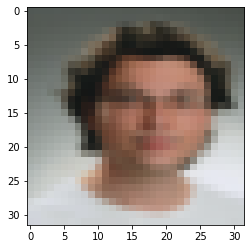

In [ ]:
transform = T.Resize((32,32))

resized_img = transform(img)
plt.imshow(resized_img)

## 2)ToTensor()


ToTensor'un kullanımı son derece kolaydır. 

In [ ]:
transform = T.ToTensor()
tensor = transform(resized_img)
print(tensor.shape)
# ----------------
transform = T.ToTensor()
tensor = transform(img)
print(tensor.shape)

torch.Size([4, 32, 32])
torch.Size([3, 442, 360])


Burada T.resize fonksiyonumuzun resmin şekli üzerindeki etkisi açık bir şekilde görülmekteidr.
torch.Size([4, 32, 32])
torch.Size([4, 442, 360])
Buradaki matris'i yukarıdada bahsettiğimiz gibi  [C, H, W] şeklinde anlamlandırabiliriz. Buradaki Birinci kısım kanal 2. kısım Yükseklik 3. kısım genişliktir. 


* **Peki kanal neden 4**
Muhtemelen H ve W değerlerinin neden 32 olduğunu anladınız. Peki kanal değeri neden 4?

  * Bu tamamen Renk modeli ile alakalıdır. 
Bizim birkaç farklı renk modelimiz var. Bunlardan en çok kullanılanlar RGB, RGBA, CMYK dır.  
RGBA ve RGB arasındaki fark A(Alfa) kanalı ile resimleri ve pikselleri transparan yapabilmemizdir. Bu A kanalı bizim matris boyutumuzudu [3,h,w] den
 [4,h,w] ye çıkarmıştır.
![img](https://i.stack.imgur.com/nnQrb.png)
![img](https://i.stack.imgur.com/YCJsx.png)
Görüldüğü gibi daha çok çıktı almak için kullanılan CMYK görüntünün 4 kanalı varken RGB görüntünün 3 kanalı vardır. Bu durumda Renk modelimiz CMYK olması bize dijital ortamda ekstra maliyet oluşturmaktadır. Aynı RGBA resimlerin A kanalıda ekstrem bir durum olmadıkça bizim için benzer bir maliyet oluşturmaktadır.
    image = image.convert('RGB')
Bu durumlarda resmimlerimizi 'RGB' ye çevirirerek normalize edebiliriz.

In [ ]:
transform = T.ToTensor()
print(resized_img.mode)
resized_img_tensor = transform(resized_img)
print(tensor.shape)
img_tensor = transform(img)
print(tensor.shape)

RGBA
torch.Size([3, 442, 360])
torch.Size([3, 442, 360])


## Normalize
Görüntü dönüşümü, görüntü piksellerinin orijinal değerlerini bir dizi yeni değerle değiştirme işlemidir. Görüntüler üzerinde yaptığımız bir dönüşüm türü, bir görüntüyü PyTorch tensörüne dönüştürmektir. Bir görüntü PyTorch tensörüne dönüştürüldüğünde, piksel değerleri 0,0 ile 1,0 arasında ölçeklendirilir. PyTorch'ta bu dönüşüm torchvision.transforms.ToTensor() kullanılarak yapılabilir. 0, 255] piksel aralığına sahip PIL görüntüsünü [0.0, 1.0] aralığına sahip (C, H, W) şeklinde bir PyTorch FloatTensörüne dönüştürür. 

Görüntülerin normalleştirilmesi, derin sinir ağları ile çalışırken çok iyi bir uygulamadır. Görüntüleri normalleştirmek, görüntüleri öyle değerlere dönüştürmek anlamına gelir ki görüntünün ortalaması ve standart sapması sırasıyla 0,0 ve 1,0 olur. Bunu yapmak için önce her bir giriş kanalından kanal ortalaması çıkarılır ve ardından sonuç kanal standart sapmasına bölünür. 


```
output[channel] = (input[channel] - mean[channel]) / std[channel]
```
### Görüntüleri neden normalleştirmeliyiz
Normalleştirme, verileri bir aralık içinde tutmaya yardımcı olur ve çarpıklığı azaltarak daha hızlı ve daha iyi öğrenmeye yardımcı olur. Normalleştirme ayrıca azalan ve patlayan gradyan sorunlarının da üstesinden gelebilir.

### PyTorch'ta Görüntüleri Normalleştirme
PyTorch'ta normalleştirme torchvision.transforms.Normalize() kullanılarak yapılır. Bu, tensör görüntüsünü ortalama ve standart sapma ile normalleştirir. 
* mean: Sequence of means for each channel.
* std: Sequence of standard deviations for each channel.
* inplace: Bool to make this operation in-place.
* Returns: Normalized Tensor image.



Text(0.5, 1.0, 'distribution of pixels')

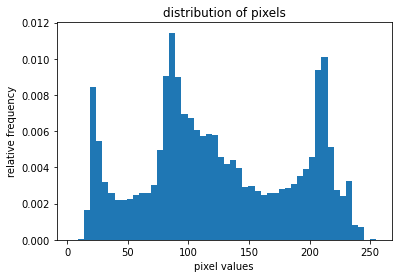

In [ ]:
img_np = np.array(img)
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")


(3, 442, 360)
477360
(477360,)


Text(0.5, 1.0, 'distribution of pixels')

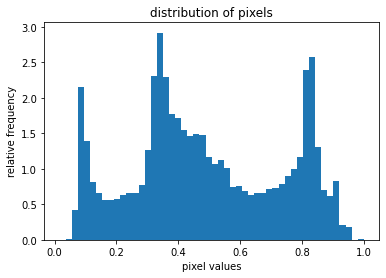

In [ ]:
img_np = np.array(img_tensor) 
print(img_np.shape)
print(3*442*360)
print(img_np.ravel().shape)
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")


Text(0.5, 1.0, 'distribution of pixels')

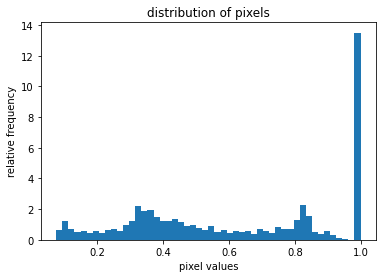

In [ ]:
img_np = np.array(resized_img_tensor) 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [ ]:
mean, std = resized_img_tensor.mean([1,2]), resized_img_tensor.std([1,2])
 
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.5322, 0.4858, 0.4534, 1.0000])
Std of the image: tensor([0.2253, 0.2274, 0.2430, 0.0000])


In [ ]:
t = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
print("Tensor:", t)

Tensor: tensor([[1., 2., 3.],
        [4., 5., 6.]])


In [ ]:
mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
t = (t-mean)/std
mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
print("Mean, std and Var after normalize:\n", mean, std, var,t)
t1 = normalize(t, p=1, dim = 0)
print(t1)

Mean, std and Var after normalize:
 tensor(0.) tensor(1.) tensor(1.) tensor([[-1.3363, -0.8018, -0.2673],
        [ 0.2673,  0.8018,  1.3363]])
tensor([[-0.8333, -0.5000, -0.1667],
        [ 0.1667,  0.5000,  0.8333]])


In [ ]:
t1 = normalize(t, p=1.0, dim = 1)
t2 = normalize(t, p=2.0, dim = 0)
print("Normalized tensor:", t1)
print("Normalized tensor:", t2)

Normalized tensor: tensor([[0.1667, 0.3333, 0.5000],
        [0.2667, 0.3333, 0.4000]])
Normalized tensor: tensor([[0.2425, 0.3714, 0.4472],
        [0.9701, 0.9285, 0.8944]])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Sinir ağını tanımlayın
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Verileri yükleyin ve normalize edin
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Sinir ağını oluşturun ve eğitin
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (ep
